In [1]:
import datetime
import sys
import os
import torch
import numpy as np
import random
from pathlib import Path
from collections import namedtuple
from miditok import REMIPlus, MMM
from miditok.constants import ADDITIONAL_TOKENS
from torch.nn import functional as F
from importlib import reload

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CTX_LEN = 1024
PRECISION = 'bf16'

os.environ['RWKV_T_MAX'] = str(CTX_LEN)
os.environ['RWKV_FLOAT_MODE'] = PRECISION

sys.path.append('./src/model')

os.getcwd()

'/media/nico/data/projects/ai/musai'

In [3]:
from runner import RWKV_RNN

In [4]:
PROJ_NAME = 'drums'
IS_BPE = True
TOKENS_PATH = f"/home/nico/data/ai/models/midi/{PROJ_NAME}{'/bpe' if IS_BPE else ''}"

Path(f'./out/{PROJ_NAME}').mkdir(parents=True, exist_ok=True)

BINS_VELOCITY = (24)
BINS_TEMPO = (24)

additional_tokens = ADDITIONAL_TOKENS
additional_tokens['Chord'] = True
additional_tokens['TimeSignature'] = True
additional_tokens['Program'] = True
additional_tokens['nb_tempos'] = BINS_TEMPO
TOKENIZER = MMM(
    additional_tokens=additional_tokens, 
    params=f'{TOKENS_PATH}/token_params.cfg',
    nb_velocities=BINS_VELOCITY
)

ORIG_VOCAB_SIZE = len(TOKENIZER.vocab)
BPE_VOCAB_SIZE = int(ORIG_VOCAB_SIZE * 1.25)

(ORIG_VOCAB_SIZE, BPE_VOCAB_SIZE, len(TOKENIZER))

(477, 596, 596)

In [5]:
N_EMBED = 768
N_LAYER = 10
CTX_LEN = 1024

params = {
    'ctx_len': CTX_LEN,
    'n_embd': N_EMBED,
    'n_layer': N_LAYER,
}

params_obj = namedtuple('RWKVParams', params.keys())(*params.values())

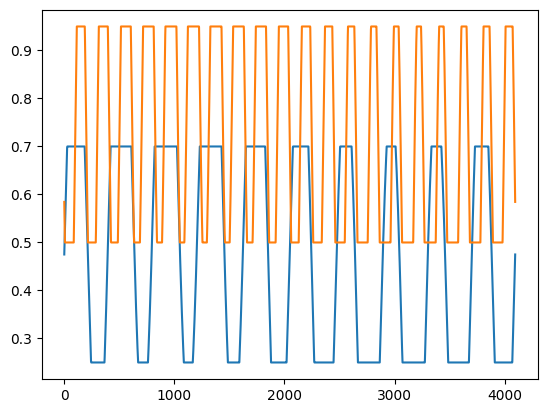

In [6]:
import matplotlib.pyplot as plt

MAX_ITER = 1024*4

# this is where we introduce some randomness
NOISE_LEVEL = 0.55
NOISE_FREQ = 10
PHASE = 0


def gen_sin_wave(total_iterations, min_value, max_value, noise_scale, noise_frequency, main_phase):
    progress = np.linspace(0, 1, total_iterations)
    main_wave = np.sin(2 * np.pi * progress + main_phase)
    noise_wave = np.sin(2 * np.pi * noise_frequency * progress - main_phase / 2)
    noise = noise_scale * noise_wave
    values = min_value + (max_value - min_value) * \
        (1 + main_wave) / 2 + noise

    # Clip values within the specified range
    np.clip(values, min_value, max_value, out=values)

    return values.tolist()


temp_values = gen_sin_wave(MAX_ITER, 0.25, 0.7, NOISE_LEVEL, NOISE_FREQ, PHASE)
top_p_values = gen_sin_wave(MAX_ITER, 0.5, 0.95, NOISE_LEVEL, NOISE_FREQ*2, PHASE+6)

plt.plot(temp_values)
plt.plot(top_p_values)

In [7]:
import types

SEED = random.randint(1000, 10000)
np.random.seed(SEED)

args = types.SimpleNamespace()
args.RUN_DEVICE = "cuda"
args.FLOAT_MODE = PRECISION
args.map_location = 'cpu'
args.base_model = f'/home/nico/dev/projects/ai/musai/out/{PROJ_NAME}/rwkv-90'
args.n_layer = params['n_layer']
args.n_embd = params['n_embd']
args.ctx_len = int(params['ctx_len'])

model_rnn = RWKV_RNN(args)
model_rnn.to(DEVICE)

copy_mask                                bfloat16   cuda:0
emb.weight                               bfloat16   cpu
blocks.0.ln1.weight                      bfloat16   cuda:0
blocks.0.ln1.bias                        bfloat16   cuda:0
blocks.0.ln2.weight                      bfloat16   cuda:0
blocks.0.ln2.bias                        bfloat16   cuda:0
blocks.0.ln0.weight                      bfloat16   cuda:0
blocks.0.ln0.bias                        bfloat16   cuda:0
blocks.0.att.time_decay                  float32    cuda:0
blocks.0.att.time_first                  float32    cuda:0
blocks.0.att.time_mix_k                  bfloat16   cuda:0
blocks.0.att.time_mix_v                  bfloat16   cuda:0
blocks.0.att.time_mix_r                  bfloat16   cuda:0
blocks.0.att.key.weight                  bfloat16   cuda:0
blocks.0.att.value.weight                bfloat16   cuda:0
blocks.0.att.receptance.weight           bfloat16   cuda:0
blocks.0.att.output.weight               bfloat16   cuda:0


RWKV_RNN()

In [12]:
import json

# initial state
pitches = [v for v in TOKENIZER.vocab.keys() if 'Pitch_' in v]

random.shuffle(pitches)

"""
REMIPlus' note seq: Program-Pitch-Velocity-Duration
Initial state should include at least one of such sequence to be reasonable.
"""
programs = [TOKENIZER.vocab[k]
            for k in TOKENIZER.vocab.keys() if 'Program' in k]
random.shuffle(programs)

init_state = None
out_tokens = []
# init_tokens = [
#     TOKENIZER.vocab['Track_Start'],
#     programs[0],
#     TOKENIZER.vocab['NoteDensity_0'],
#     TOKENIZER.vocab['Bar_Start'],
#     TOKENIZER.vocab[pitches[0]]
# ]

tokens_file_paths = list(Path(TOKENS_PATH).glob('*.json'))

random.shuffle(tokens_file_paths)

token_ids = json.load(open(tokens_file_paths[0]))['ids']
max_seq = int(len(token_ids)*.1)
init_tokens = token_ids[:max_seq]
init_ctx = []

In [13]:
from runner import sample_logits, repetition_penalty

for n in range(len(init_tokens)):
    init_out, init_state = model_rnn.forward([init_tokens[n]], init_state)
    out_token = sample_logits(
        init_out.detach().cpu(), temperature=temp_values[n], top_p=top_p_values[n])

    init_ctx.append(out_token)

for i in range(MAX_ITER):
    out, init_state = model_rnn.forward(
        init_ctx if i == 0 else out_tokens[-1:], init_state)

    # ignore padding
    out[0] = -float('inf')

    # apply repetition penalty
    out = repetition_penalty(out, out_tokens, [4, 5, 6, 7])

    out_token = sample_logits(
        out.detach().cpu(), temperature=temp_values[i], top_p=top_p_values[i])

    out_tokens.append(out_token)


In [22]:
key_list = list(TOKENIZER.vocab_bpe.keys())
val_list = list(TOKENIZER.vocab_bpe.values())
vocab_bpe_tokens = TOKENIZER._vocab_bpe_bytes_to_tokens

vocab_tokens = [
    vocab_bpe_tokens[key_list[val_list.index(token)]] for token in out_tokens]
vocab_tokens

[['Velocity_63'],
 ['Duration_0.1.8', 'Pitch_54'],
 ['Velocity_42', 'Duration_0.1.8'],
 ['Pitch_68'],
 ['Velocity_58', 'Duration_0.1.8'],
 ['TimeShift_1.0.8', 'Pitch_40'],
 ['Velocity_105', 'Duration_0.1.8'],
 ['Pitch_44'],
 ['Velocity_89', 'Duration_0.1.8', 'Pitch_54'],
 ['Velocity_121', 'Duration_0.1.8'],
 ['Pitch_73'],
 ['Velocity_121', 'Duration_0.1.8'],
 ['TimeShift_1.0.8', 'Pitch_36'],
 ['Velocity_63', 'Duration_0.1.8'],
 ['Pitch_39'],
 ['Velocity_111', 'Duration_0.1.8'],
 ['Pitch_40'],
 ['Velocity_63', 'Duration_0.1.8'],
 ['Pitch_44'],
 ['Velocity_89', 'Duration_0.1.8', 'Pitch_54'],
 ['Velocity_121'],
 ['Duration_0.1.8', 'TimeShift_0.4.8'],
 ['Pitch_39'],
 ['Velocity_111', 'Duration_0.1.8'],
 ['Pitch_40'],
 ['Velocity_52'],
 ['Duration_0.1.8', 'Pitch_42'],
 ['Velocity_47'],
 ['Duration_0.1.8', 'Pitch_54'],
 ['Velocity_26'],
 ['Duration_0.1.8'],
 ['Pitch_66'],
 ['Velocity_42'],
 ['Duration_0.1.8', 'TimeShift_0.2.8'],
 ['Pitch_39'],
 ['Velocity_105', 'Duration_0.1.8'],
 ['Pitch_40

In [15]:
import re

d = datetime.datetime.now().isoformat()
d = re.sub(r'[^\dT]{1,}', '-', d)
fname = f'out/{PROJ_NAME}/{d}.mid'

TOKENIZER(out_tokens).dump(fname)